In [1]:
import matplotlib

import logging
import torch

from data.data_loader import Dataset
from data.germeval2017 import germeval2017_dataset

from misc.preferences import PREFERENCES
from misc.visualizer import *
from misc.run_configuration import get_default_params
from misc import utils

from optimizer import get_default_optimizer
from criterion import NllLoss

from models.transformer.encoder import TransformerEncoder
from models.softmax_output import SoftmaxOutputLayer, OutputLayer, SoftmaxOutputLayerWithCommentWiseClass
from models.transformer_tagger import TransformerTagger
from models.transformer.train import Trainer

C:\Users\felix\Anaconda3\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
experiment_name = 'FastText'
use_cuda = True

In [5]:
utils.get_current_git_commit()

"b'a38d191'"

In [6]:
PREFERENCES.defaults(
    data_root='./data/germeval2017',
    data_train='train_v1.4.tsv',    
    data_validation='dev_v1.4.tsv',
    data_test='test_TIMESTAMP1.tsv',
    early_stopping='highest_5_F1'
)

hyperparameters = get_default_params()
hyperparameters.model_size = 300
hyperparameters.batch_size = 12
hyperparameters.num_encoder_blocks = 4
hyperparameters.early_stopping = -1
hyperparameters.use_cuda = use_cuda
hyperparameters.language = 'de'
hyperparameters.num_epochs = 25
hyperparameters.log_every_xth_iteration = -1
hyperparameters.embedding_type = 'fasttext'

experiment_name = utils.create_loggers(experiment_name=experiment_name)

Log path is  C:\Users\felix\OneDrive\Studium\Studium\6. Semester\MA\Project\ABSA-Transformer\logs\FastText


In [7]:
dataset = Dataset(
    'germeval',
    logging.getLogger('data_loaoder'),
    hyperparameters,
    source_index=0,
    target_vocab_index=1,
    data_path=PREFERENCES.data_root,
    train_file=PREFERENCES.data_train,
    valid_file=PREFERENCES.data_validation,
    test_file=PREFERENCES.data_test,
    file_format='.tsv',
    init_token=None,
    eos_token=None
)
dataset.load_data(germeval2017_dataset)

A Jupyter Widget


Train loading finished


A Jupyter Widget

A Jupyter Widget


+-------------------------+
|  GERM EVAL 2017 DATASET |
+---------------+---------+
|     Split     |   Size  |
+---------------+---------+
|     train     |  17043  |
|   validation  |   2049  |
|      test     |   2095  |
+---------------+---------+
+--------------------------------------+
|           Vocabulary Stats           |
+------------------------------+-------+
|          Vocabulary          |  Size |
+------------------------------+-------+
|           comments           | 95112 |
|      general_sentiments      |   3   |
|           padding            | 33785 |
|          Sicherheit          |   4   |
|        Informationen         |   4   |
|            Image             |   4   |
|          Toiletten           |   4   |
| Service_und_Kundenbetreuung  |   4   |
|      DB_App_und_Website      |   4   |
|   Gastronomisches_Angebot    |   4   |
|            Gepäck            |   4   |
|          Atmosphäre          |   4   |
|           QR-Code            |   3   |
|        

In [8]:
print(dataset.class_weights)
print(dataset.class_labels)

[0.3781024467523323, 0.6932464941618259, 0.9286510590858417]
['neutral', 'negative', 'positive']


In [9]:
loss = NllLoss(dataset.target_size, dataset.class_weights)
transformer = TransformerEncoder(dataset.source_embedding,
                                 hyperparameters=hyperparameters)
tagging_softmax = SoftmaxOutputLayerWithCommentWiseClass(hyperparameters.model_size, dataset.target_size)
model = TransformerTagger(transformer, tagging_softmax)

In [10]:
hyperparameters.num_epochs = 15

optimizer = get_default_optimizer(model, hyperparameters)
trainer = Trainer(
                    model,
                    loss,
                    optimizer,
                    hyperparameters,
                    dataset,
                    experiment_name,
                    enable_tensorboard=True)

pre_training - INFO - TransformerTagger (
  (encoder): TransformerEncoder(
    (src_embeddings): Embedding(95112, 300)
    (positional_encoding): PositionalEncoding2(
      (dropout): Dropout(p=0.1)
    )
    (encoder_blocks): ModuleList(
      (0): EncoderBlock(
        (self_attention_layer): MultiHeadedSelfAttentionLayer(
          (query_projections): Linear(in_features=300, out_features=300, bias=False)
          (key_projections): Linear(in_features=300, out_features=300, bias=False)
          (value_projections): Linear(in_features=300, out_features=300, bias=False)
          (attention_layer): ScaledDotProductAttentionLayer(
            (dropout): Dropout(p=0.1)
          )
          (layer_norm): LayerNorm()
          (w_0): Linear(in_features=300, out_features=300, bias=False)
          (dropout): Dropout(p=0.1)
        )
        (feed_forward_layer): PointWiseFCLayer(
          (layer_norm): LayerNorm()
          (w_1): Linear(in_features=300, out_features=2048, bias=True)
 


pre_training - INFO - Classes: ['neutral', 'negative', 'positive']
pre_training - INFO - Tensorboard enabled. Run will be located at /runs/FastText/20190123/15/0/. Full path is C:\Users\felix\OneDrive\Studium\Studium\6. Semester\MA\Project\ABSA-Transformer\runs\FastText\20190123\15EP\0


In [11]:
result = trainer.train(use_cuda=hyperparameters.use_cuda, perform_evaluation=False)

pre_training - DEBUG - train with cuda support
pre_training - INFO - 1421 Iterations per epoch with batch size of 12
pre_training - INFO - START training.





A Jupyter Widget

A Jupyter Widget

# EP	# IT	tr loss		val loss	f1		acc		duration / total time
1	1421	97.483		25.229		0.301		0.301		4.19m - 4.2m / 0.0m


A Jupyter Widget

A Jupyter Widget

2	2842	25.751		1.971		0.646		0.646		4.25m - 8.5m / 62.8m


A Jupyter Widget

A Jupyter Widget

3	4263	9.144		0.952		0.597		0.597		4.16m - 12.8m / 63.9m


A Jupyter Widget

A Jupyter Widget

4	5684	5.608		1.047		0.612		0.612		4.38m - 17.5m / 63.0m


A Jupyter Widget

A Jupyter Widget

5	7105	2.324		1.054		0.590		0.590		4.08m - 21.7m / 65.8m


A Jupyter Widget

A Jupyter Widget

6	8526	1.122		0.970		0.644		0.644		4.06m - 26.0m / 62.7m


A Jupyter Widget

A Jupyter Widget

7	9947	0.691		0.984		0.665		0.665		4.19m - 30.5m / 62.8m


A Jupyter Widget

A Jupyter Widget

8	11368	0.565		0.957		0.676		0.676		4.17m - 34.6m / 64.0m


A Jupyter Widget

A Jupyter Widget

9	12789	0.466		0.959		0.564		0.564		4.19m - 38.9m / 63.8m


A Jupyter Widget

A Jupyter Widget

10	14210	0.382		1.076		0.530		0.530		4.32m - 43.4m / 64.2m


A Jupyter Widget

A Jupyter Widget

11	15631	0.350		1.039		0.680		0.680		4.19m - 47.6m / 65.0m


A Jupyter Widget

A Jupyter Widget

12	17052	0.309		1.040		0.667		0.667		4.26m - 51.9m / 64.5m


A Jupyter Widget

A Jupyter Widget

13	18473	0.278		1.168		0.656		0.656		4.14m - 56.1m / 64.8m


A Jupyter Widget

A Jupyter Widget

14	19894	0.275		1.109		0.594		0.594		4.21m - 60.5m / 64.5m


A Jupyter Widget

A Jupyter Widget

15	21315	0.238		1.114		0.713		0.713		4.22m - 64.9m / 64.9m


In [12]:
plt.rcParams['figure.figsize'] = [15, 15]

In [13]:
model = result['model']

In [ ]:
result_labels = trainer.classify_sentence('I was born in 1993 in Stuttgart')



print(result_labels)

In [ ]:
tr = trainer.text_reverser[1]
lr = trainer.label_reverser

test_sentence = ['china', 'controlled', 'most', 'of', 'the', 'match']
test_sentence

In [ ]:
test_sentence = tr.preprocess('Die Bahn ist nicht gut')

#test_sentence = tr.preprocess('china controlled most of the match on 1993')
test_sentence = [x.strip(' ') for x in test_sentence]
test_sentence = [test_sentence]
test_sentence

In [ ]:

#test = tr.preprocess('china controlled most of the match')
#print(test)

#test_sentence = [['china', 'controlled', 'most', 'of', 'the', 'match']]
x = tr.process(test_sentence)

print("X TENSOR ",x)
print('X Size', x.size())
print("Reversed X", tr.reverse(x))
x = x.cuda()
y_hat = model.predict(x)
y_hat_label = lr.reverse(y_hat)
print(y_hat_label)



pre_training - INFO - Perform final model evaluation
pre_training - DEBUG - --- Train Scores ---


A Jupyter Widget

pre_training - INFO - TRAIN loss:	0.20878428778128946
pre_training - INFO - TRAIN f1-s:	0.9648721557588552
pre_training - INFO - TRAIN accuracy:	0.9648536055858711
pre_training - DEBUG - --- Valid Scores ---


A Jupyter Widget

pre_training - INFO - VALID loss:	1.1196516035344803
pre_training - INFO - VALID f1-s:	0.7120546608101513
pre_training - INFO - VALID accuracy:	0.7120546608101513


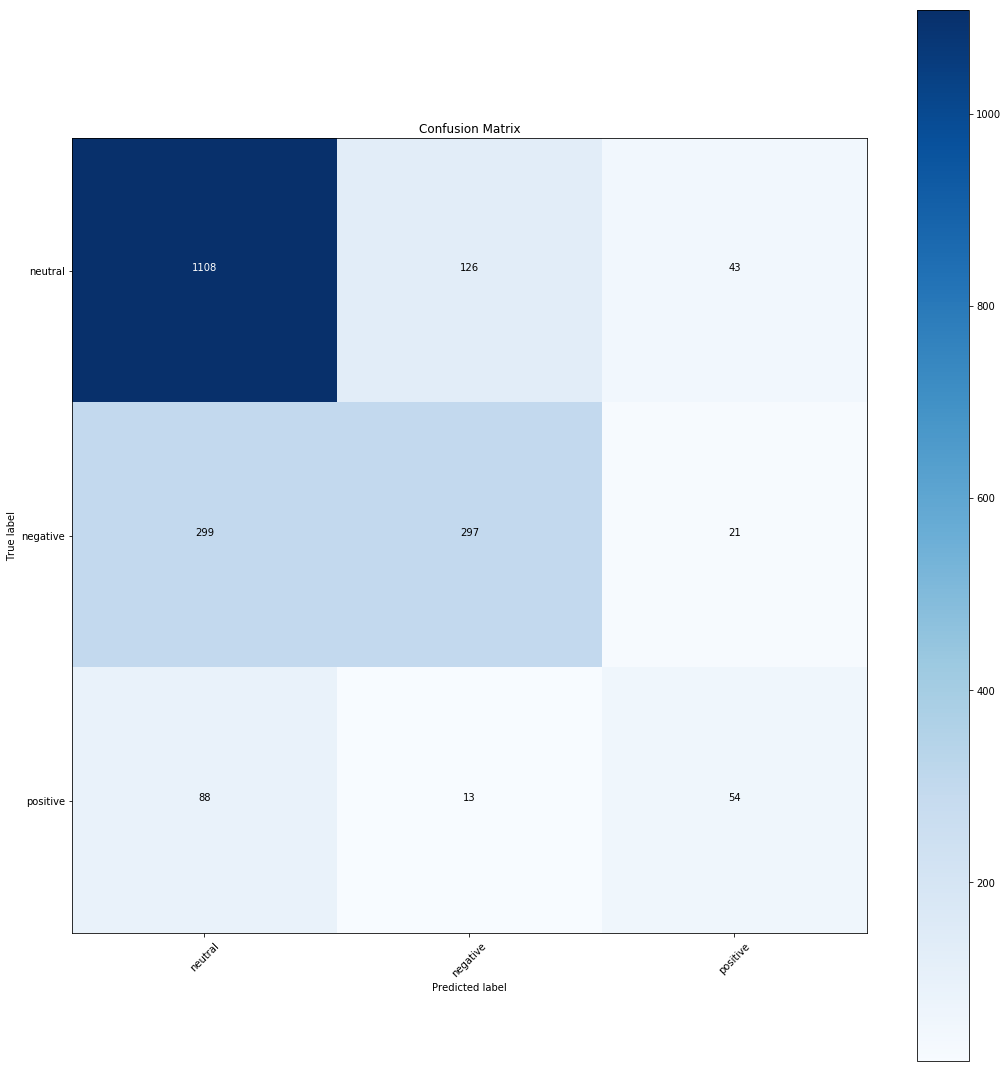

A Jupyter Widget

pre_training - INFO - TEST loss:	1.263197544931059
pre_training - INFO - TEST f1-s:	0.665871121718377
pre_training - INFO - TEST accuracy:	0.665871121718377


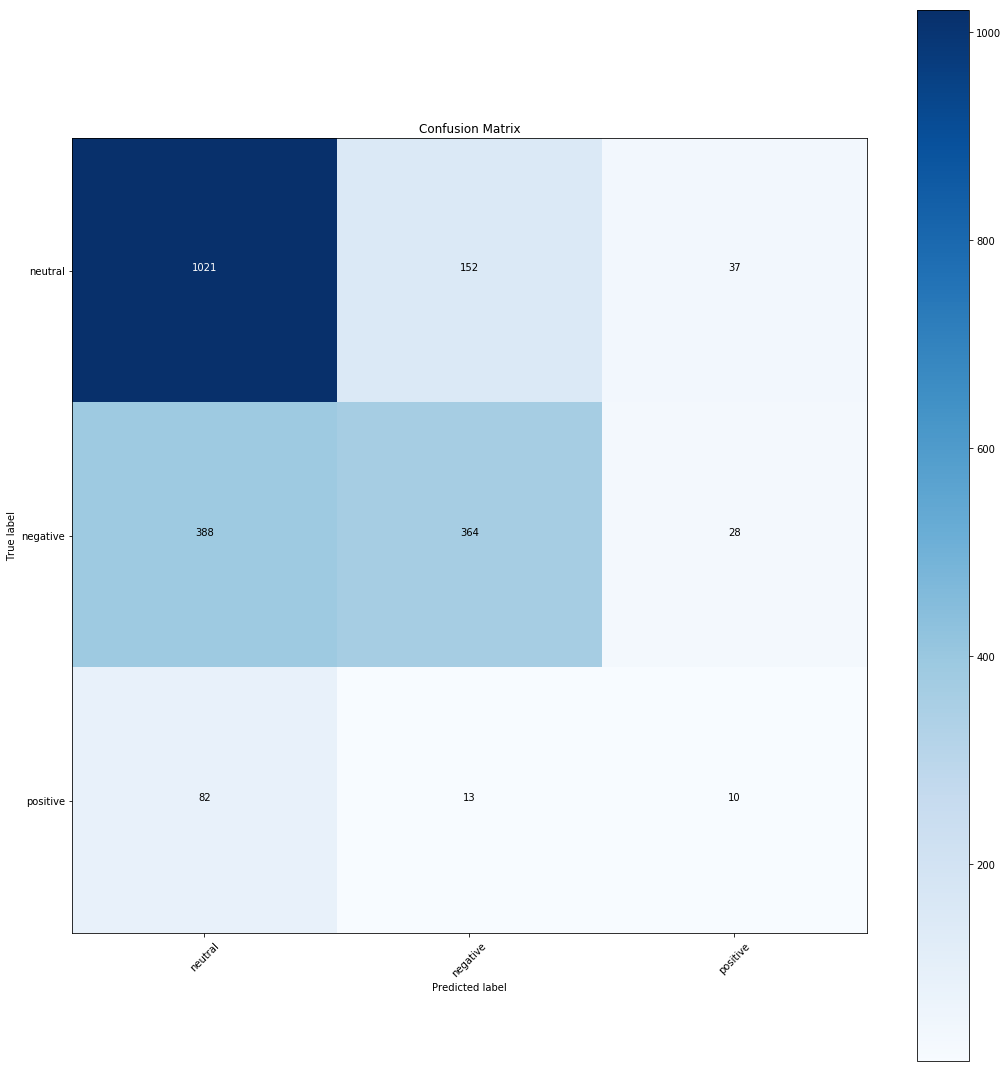

In [14]:
trainer.tb_writer = None
trainer.enable_tensorboard = False
evaluation_results = trainer.perform_final_evaluation()

In [15]:
c_matrix = evaluation_results[1][2]
c_matrix

array([[1108,  126,   43],
       [ 299,  297,   21],
       [  88,   13,   54]], dtype=int64)

In [ ]:
fig = plot_confusion_matrix(c_matrix, class_labels)
plt.show()

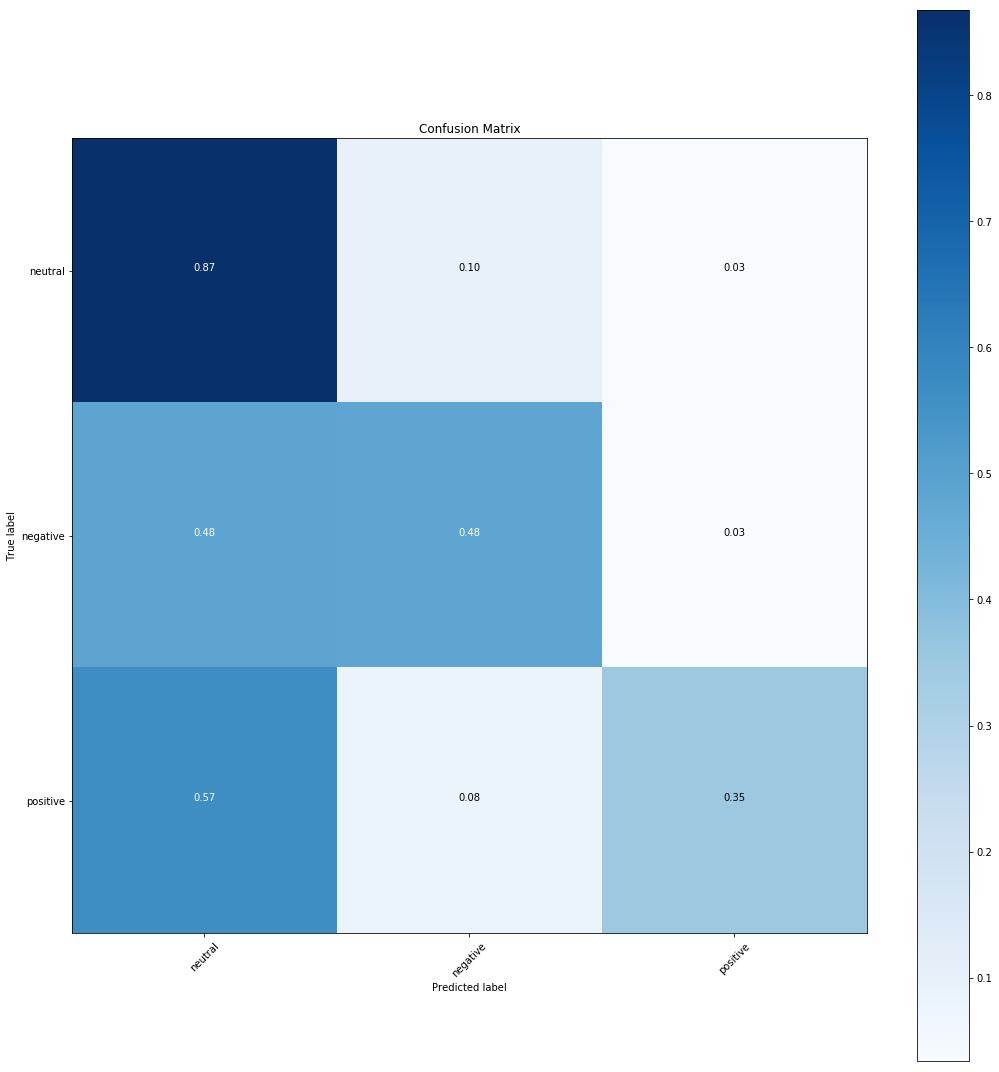

In [16]:
fig = plot_confusion_matrix(c_matrix, dataset.class_labels, normalize=True)
plt.show()

In [ ]:
# predict now to see model in final state
from IPython.display import display, HTML

df = predict_some_examples_to_df(model, conll2003['iters'][2], num_samples=800)
display(HTML(df.to_html()))

In [ ]:
df = predict_some_examples_to_df(model, conll2003['iters'][1], num_samples=800)
display(HTML(df.to_html()))

In [ ]:
df = predict_some_examples_to_df(model, conll2003['iters'][0], num_samples=800)
display(HTML(df.to_html()))

In [ ]:
import numpy as np
a = np.array([
    np.array([[1, 1], [1, 1]]),
    np.array([[2, 2], [-2, -3]])
])
print(a)

In [ ]:
a.sum(axis=0)

In [ ]:
#df = predict_some_examples_to_df(model, test_sample_iter)
#print(df)

In [ ]:
#print(result)

In [ ]:
(tr_loss, tr_f1) = result['result_train']
